In [1]:
import pandas as pd
import sqlite3
import struct
import matplotlib.pyplot as plt


# Get Tables from DB into DataFrame

In [2]:
conn = sqlite3.connect("book-rec-sys/books_recommendation.db")
cursor = conn.cursor()

In [3]:

# Query to get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print table names
for table in tables:
    print(table[0])

books
user_interactions
sqlite_sequence


In [4]:
def decode_sqlite_binary_result(cursor, rows):
    """
    Converts binary fields in SQLite rows to readable integers and returns column names.
    
    Args:
        cursor (sqlite3.Cursor): Cursor used for the query (for getting column names).
        rows (list of tuples): Rows returned from the query.

    Returns:
        tuple: (column_names, decoded_rows)
    """
    column_names = [desc[0] for desc in cursor.description]
    decoded_rows = []

    for row in rows:
        new_row = []
        for value in row:
            if isinstance(value, bytes) and len(value) == 8:
                try:
                    value = struct.unpack('<Q', value)[0]
                except struct.error:
                    pass  # Leave unchanged if unpacking fails
            new_row.append(value)
        decoded_rows.append(tuple(new_row))

    return column_names, decoded_rows


In [5]:
cursor.execute("SELECT * FROM user_interactions;")
rows = cursor.fetchall()

In [6]:
column_names, decoded_rows = decode_sqlite_binary_result(cursor, rows)

In [7]:
interactions_df = pd.DataFrame(decoded_rows, columns=column_names)

In [8]:
print(interactions_df.head)

<bound method NDFrame.head of       interaction_id  user_id   book_id  is_read  rating  is_reviewed
0                  1        0    452196        1       4            0
1                  2        0     12067        0       0            0
2                  3        0    108905        1       4            1
3                  4        0    178186        1       5            1
4                  5        0    150731        0       0            0
...              ...      ...       ...      ...     ...          ...
1696            1697      226  25876779        1       3            0
1697            1698      226   6369113        0       0            0
1698            1699      226   8449713        0       0            0
1699            1700      227   6320534        1       4            0
1700            1701      227    349473        0       0            0

[1701 rows x 6 columns]>


In [9]:
conn.close()

# EDA

### for user_interactions

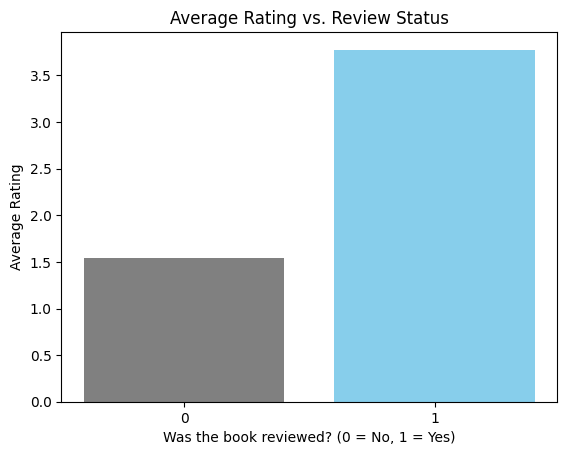

In [10]:
import matplotlib.pyplot as plt

# Group by review status and compute average rating
avg_ratings = interactions_df.groupby('is_reviewed')['rating'].mean()

# Create bar chart
plt.bar(avg_ratings.index.astype(str), avg_ratings.values, color=['gray', 'skyblue'])

# Set titles and labels
plt.title("Average Rating vs. Review Status")
plt.xlabel("Was the book reviewed? (0 = No, 1 = Yes)")
plt.ylabel("Average Rating")

plt.show()

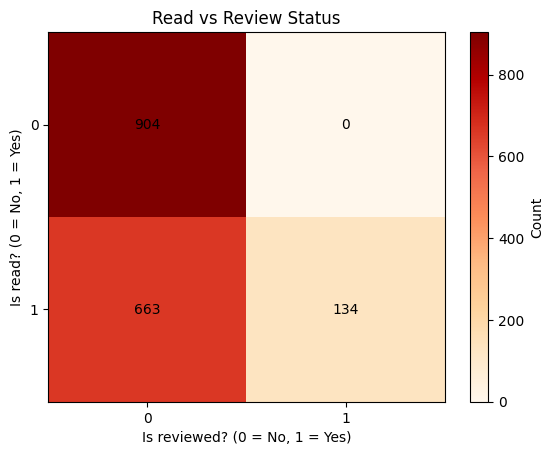

In [11]:
# Create 2D frequency table
heatmap_data = pd.crosstab(interactions_df['is_read'], interactions_df['is_reviewed'])

# Convert to NumPy array for imshow
data_array = heatmap_data.values

# Plot heatmap
plt.imshow(data_array, cmap='OrRd', aspect='auto')

# Add color bar
plt.colorbar(label='Count')

# Set axis labels
plt.title("Read vs Review Status")
plt.xlabel("Is reviewed? (0 = No, 1 = Yes)")
plt.ylabel("Is read? (0 = No, 1 = Yes)")

# Set tick labels
plt.xticks(ticks=range(len(heatmap_data.columns)), labels=heatmap_data.columns)
plt.yticks(ticks=range(len(heatmap_data.index)), labels=heatmap_data.index)

for i in range(data_array.shape[0]):
    for j in range(data_array.shape[1]):
        plt.text(j, i, str(data_array[i, j]), ha='center', va='center', color='black')

plt.show()

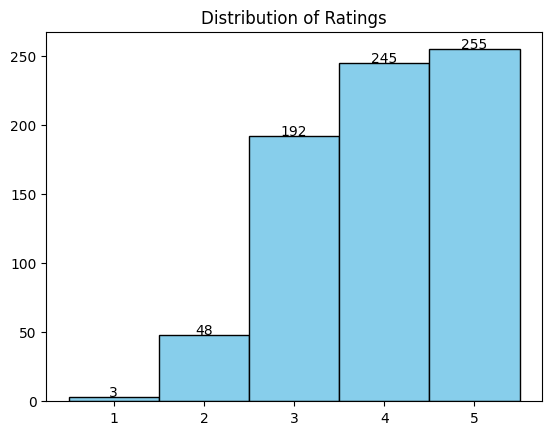

In [12]:
# histogram of ratings
 
plt.title("Distribution of Ratings")
 
counts, bins, patches = plt.hist(interactions_df['rating'], bins=range(1, 7), align='left', edgecolor='black', color='skyblue')
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count + 0.5, int(count), ha='center')